## <font style = "color:rgb(50,120,229)">Read Image</font>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [4]:
im =  cv2.imread("emir.jpg", cv2.IMREAD_GRAYSCALE)

In [5]:
# Find the width and height of the color image
sz = im.shape
print(sz)

height = int(sz[0] / 3);
width = sz[1]

(1300, 500)


In [6]:
# Extract the three channels from the gray scale image
# and merge the three channels into one color image
im_color = np.zeros((height,width,3), dtype=np.uint8 )
for i in range(0,3) :
    im_color[:,:,i] = im[ i * height:(i+1) * height,:]

In [7]:
blue = im_color[:,:,0]
green = im_color[:,:,1]
red = im_color[:,:,2]

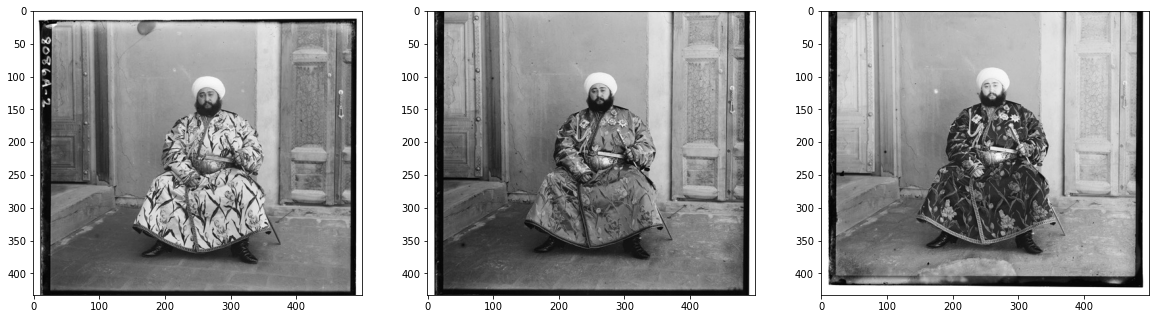

In [8]:
plt.figure(figsize=(20,12))
plt.subplot(1,3,1)
plt.imshow(blue)
plt.subplot(1,3,2)
plt.imshow(green)
plt.subplot(1,3,3)
plt.imshow(red)
plt.show()

In [67]:
MAX_FEATURES = 5000
GOOD_MATCH_PERCENT = 0.015

In [68]:
orb = cv2.ORB_create(MAX_FEATURES)
keypointsBlue, descriptorsBlue = orb.detectAndCompute(blue, None)
keypointsGreen, descriptorsGreen = orb.detectAndCompute(green, None)
keypointsRed, descriptorsRed = orb.detectAndCompute(red, None)

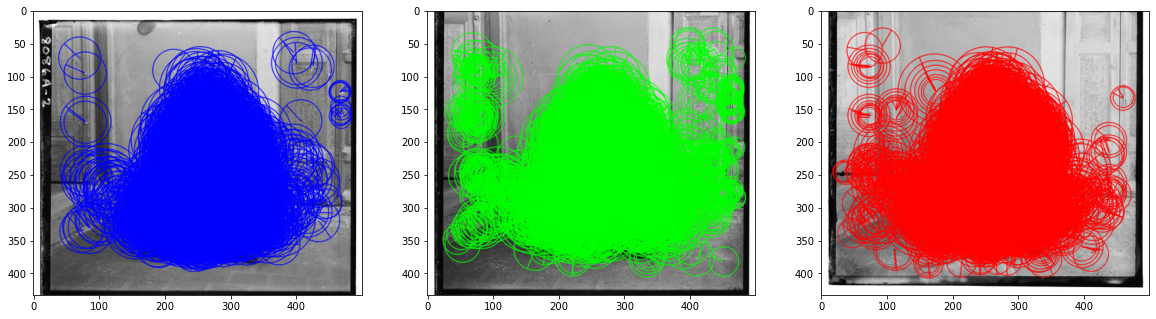

In [69]:
plt.figure(figsize=[20,10])
img2 = cv2.drawKeypoints(blue, keypointsBlue, None, color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(131);plt.imshow(img2[...,::-1])

img2 = cv2.drawKeypoints(green, keypointsGreen, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(132);plt.imshow(img2[...,::-1])

img2 = cv2.drawKeypoints(red, keypointsRed, None, color=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(133);plt.imshow(img2[...,::-1])


## <font style = "color:rgb(50,120,229)">Match Features</font>

In [70]:
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matchesBlueGreen = matcher.match(descriptorsBlue, descriptorsGreen, None)


# Sort matches by score
matchesBlueGreen = list(matchesBlueGreen)

# Sort the list based on the first element of each tuple
matchesBlueGreen.sort(key=lambda x: x.distance, reverse=False)

matchesBlueGreen = tuple(matchesBlueGreen)

# Remove not so good matches
numGoodMatches = int(len(matchesBlueGreen) * GOOD_MATCH_PERCENT)
matchesBlueGreen = matchesBlueGreen[:numGoodMatches]

# Draw top matches
imMatchesBlueGreen = cv2.drawMatches(blue, keypointsBlue, green, keypointsGreen, matchesBlueGreen, None)

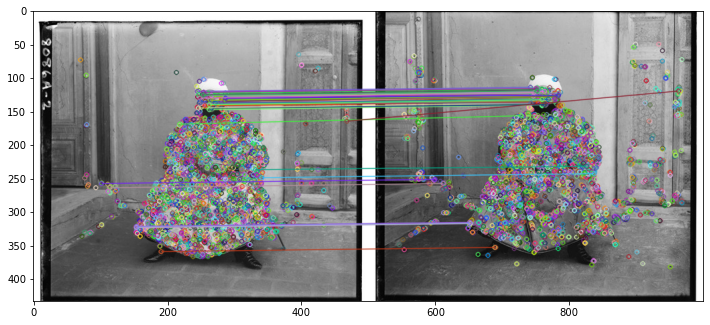

In [71]:
plt.figure(figsize=(12,12))
plt.imshow(imMatchesBlueGreen[:,:,::-1])
plt.show()

In [72]:

# Match features between Red and Green channels
matchesRedGreen = matcher.match(descriptorsRed, descriptorsGreen, None)

# Sort matches by score
matchesRedGreen = list(matchesRedGreen)

# Sort the list based on the first element of each tuple
matchesRedGreen.sort(key=lambda x: x.distance, reverse=False)


matchesRedGreen = tuple(matchesRedGreen)

# Remove not so good matches
numGoodMatches = int(len(matchesRedGreen) * GOOD_MATCH_PERCENT)
matchesRedGreen = matchesRedGreen[:numGoodMatches]

# Draw top matches
imMatchesRedGreen = cv2.drawMatches(red, keypointsRed, green, keypointsGreen, matchesRedGreen, None)

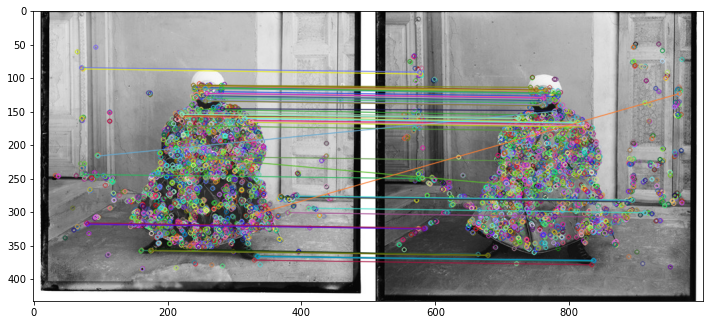

In [73]:
plt.figure(figsize=(12,12))
plt.imshow(imMatchesRedGreen[:,:,::-1])
plt.show()

## <font style = "color:rgb(50,120,229)">Calculate Homography</font>


In [74]:
# Extract location of good matches

points1 = np.zeros((len(matchesBlueGreen), 2), dtype=np.float32)
points2 = np.zeros((len(matchesBlueGreen), 2), dtype=np.float32)

for i, match in enumerate(matchesBlueGreen):
    points1[i, :] = keypointsBlue[match.queryIdx].pt
    points2[i, :] = keypointsGreen[match.trainIdx].pt


hBlueGreen, mask = cv2.findHomography(points1, points2, cv2.RANSAC)




Similarly, we can calculate the homography between Green and Red channels.

In [75]:
# Extract location of good matches

points3 = np.zeros((len(matchesRedGreen), 2), dtype=np.float32)
points4 = np.zeros((len(matchesRedGreen), 2), dtype=np.float32)

for i, match in enumerate(matchesRedGreen):
    points3[i, :] = keypointsRed[match.queryIdx].pt
    points4[i, :] = keypointsGreen[match.trainIdx].pt

# Find homography
hRedGreen, mask = cv2.findHomography(points3, points4, cv2.RANSAC)
# Find homography



## <font style = "color:rgb(50,120,229)">Warping Image</font>



In [76]:
# Use homography to find blueWarped and RedWarped images

blueWarped = cv2.warpPerspective(blue, hBlueGreen, (width, height))
redWarped = cv2.warpPerspective(red, hRedGreen, (width, height))

Text(0.5, 1.0, 'Red channel aligned w.r.t green channel')

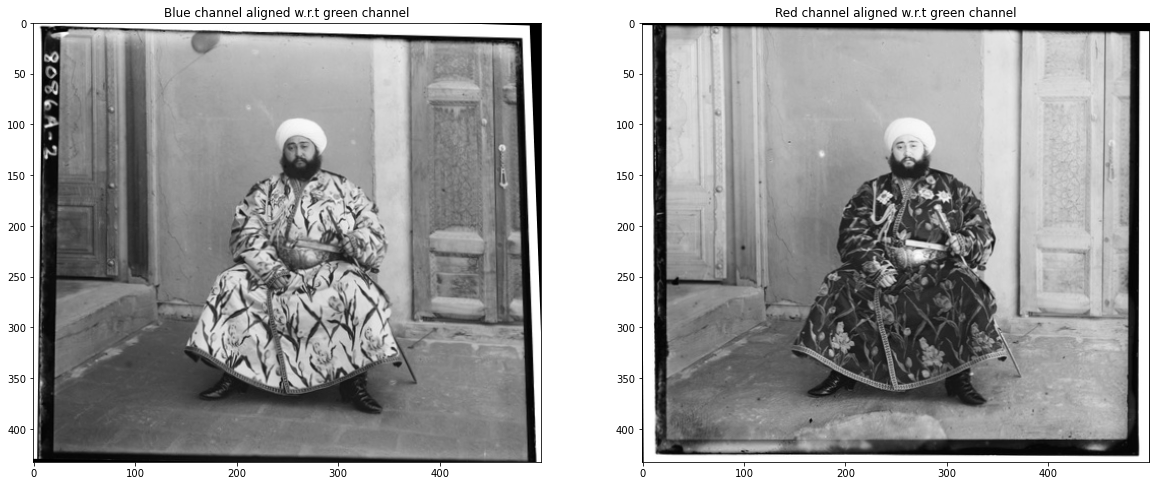

In [77]:
plt.figure(figsize=(20,10))
plt.subplot(121);plt.imshow(blueWarped);plt.title("Blue channel aligned w.r.t green channel")
plt.subplot(122);plt.imshow(redWarped);plt.title("Red channel aligned w.r.t green channel")

In [78]:
colorImage = cv2.merge((blueWarped,green,redWarped))

In [79]:
originalImage = cv2.merge((blue,green,red))

Text(0.5, 1.0, 'Aligned Image')

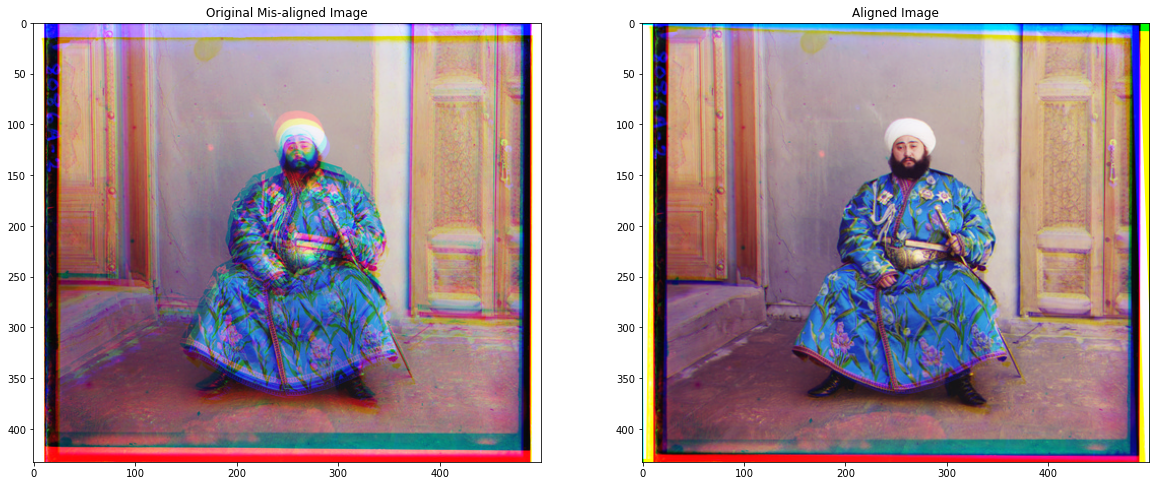

In [80]:
plt.figure(figsize=(20,10))
plt.subplot(121);plt.imshow(originalImage[:,:,::-1]);plt.title("Original Mis-aligned Image")
plt.subplot(122);plt.imshow(colorImage[:,:,::-1]);plt.title("Aligned Image")